In [1]:
#1) for hurricane dictionary
#https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-atl-1851-2021.pdf schema


#2) for download image data
#https://oceancolor.gsfc.nasa.gov/data/download_methods/#appkey
apiKey = '?appkey=5c78cd36e3946b34e84f0e6024d31e377051b942'

# wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --content-disposition https://oceandata.sci.gsfc.nasa.gov/ob/getfile/T2017004001500.L1A_LAC.bz2?appkey=5c78cd36e3946b34e84f0e6024d31e377051b942 --no-check-certificate

import urllib.request as urllib2
#open url
target_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2021-041922.txt'
data = urllib2.urlopen(target_url)


#read hurricane file into a dictionary  keyed by ID
hurricane_dict = {}
curr_hurricane = None
for line in data: 
    line = line.decode('utf-8').replace(' ', '')
    arr = line.split(',')
    
    if len(arr) == 4:  # hurricane names add a new hurricane
        if arr[1] in hurricane_dict.keys():
            print ('duplicate hurricane dropped', arr[1])
            continue
        hurricane_dict[arr[0]] = {'id': arr[0], 'name': arr[1], 'num_of_records': int(arr[2]), 'path': []}
        curr_hurricane = arr[0]
    elif len(arr) > 4:
        rec = {'date': int(arr[0]), 'time': arr[1], 'category':arr[3],
               'lt':arr[4], 'lg':arr[5], 'maxwind':arr[6], 'maxpres':arr[7],
              '34ktne':arr[8], '34ktse':arr[9], '34ktsw':arr[9], '34ktnw':arr[10],
              '50ktne':arr[11], '50ktse':arr[12], '50ktsw':arr[13], '50ktnw':arr[14], 
               '64ktne':arr[15], '64ktse':arr[16], '64ktsw':arr[17], '64ktnw':arr[18], 
               'maxwindradius':arr[19]
              }
        hurricane_dict[curr_hurricane]['path'].append(rec)
    

In [2]:
#test hdf5 imerg

#imerg_df = pd.read_hdf('/home/fun/data/imerg/3B-HHR.MS.MRG.3IMERG.20121021-S023000-E025959.0150.V06B.HDF5')  

import h5py

f = h5py.File('/home/fun/data/imerg/3B-HHR.MS.MRG.3IMERG.20121021-S023000-E025959.0150.V06B.HDF5', 'r')

for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset
    
#Get the HDF5 group; key needs to be a group name from above
group = f['Grid']

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)
    
longitude = group['lon'][()] # len 3600, x-axis
latitude = group['lat'][()] # len 1800, y-axis
rain = group['precipitationCal'][()] # array of shape (1, 3600, 1800)

lon = -77.4
lat = 14.3

print(latitude, clos_coords)
i = int((lat-latitude[0])*10)
j = int((lon-longitude[0])*10)
print(latitude[i], longitude[j])

rain = rain.reshape(3600, 1800)
rain[i][j]

OSError: Unable to open file (unable to open file: name = '/home/fun/data/imerg/3B-HHR.MS.MRG.3IMERG.20121021-S023000-E025959.0150.V06B.HDF5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
#3) generate data holders for each hurriacne

import json
import os
count = 0
for key, val in hurricane_dict.items():

    if val['path'][0]['date'] >= 19970101:

        directory = '/home/fun/data/' + str(key)
        os.makedirs(directory)

        filename = '/home/fun/data/' + str(key) + '/profile.json'
        out_file = open(filename, "x")

        json.dump(hurricane_dict[key], out_file, indent = 6)
        out_file.close()

FileExistsError: [Errno 17] File exists: '/home/fun/data/AL011997'

In [4]:
#5 generate dataframe for rain data on huriacane path
#step 2 by location
# for every time stamp, the satellite takes an image in a large cone with 7x7 spatial resolution
#step 2 by location
# for every time stamp, the satellite takes an image in a large cone with 7x7 spatial resolution.
import numpy as np
import glob
import h5py

def search_location_in_hdf(filename, n, m, results_dict):
    hdf = SD.SD(filename) # first day of hurricane sandy
    v_scanTime = hdf.select('scanTime_sec')
    v_rain = hdf.select('rain')
    v_lat = hdf.select('Latitude')
    v_long = hdf.select('Longitude')
    lat_delta = 0.05
    long_delta = 0.02

    lav = v_lat.get()
    lgv = v_long.get()

    results = []
    for i in range(len(lav)): # filter first by closest latitude
        lat = lav[i]    
        lg = lgv[i]

        if (abs(lat[0] -n) < lat_delta * 49) and (abs(lg[0] -m) < long_delta *49):
            results.append(i)
    
    results_dict[filename] = results
    
                
#             long = v_long.get()[i]
#             clos_coords = pd.DataFrame([(lat, long, i)], columns = ['Latitude', 'Longitude', 'Index'])
#             closest = pd.concat([closest, clos_coords], ignore_index = True)

results={}
for name in glob.glob('/home/fun/data/AL182012/*.HDF'):
    print(name)
    search_location_in_hdf(name, 14.3, -77.4, results)

print (results)

#result_index = closest['Longitude'].sub(long).abs().idxmin() # then filter by closest longitude
# result is the index of the location that most closely matches the desired coordinates
# index represents the index in the original list when looking at the rain_type array

{}


In [248]:

df = pd.DataFrame()

for key, val in results.items():
    indices = []
    if len(val) > 0: # corresponds to one file
        hdf = SD.SD(key) # first day of hurricane sandy
        v_scanTime = hdf.select('scanTime_sec')
        v_rain = hdf.select('nearSurfRain')
        v_lat = hdf.select('Latitude')
        v_long = hdf.select('Longitude')
        indices.extend(val)
        
        for i in val:
            df_temp = pd.DataFrame({'scanTime': v_scanTime[i], 'Latitude':v_lat[i],'Longitude': v_long[i], 'nearSurfRain': v_rain[i], 'Index': i})
            df = pd.concat([df, df_temp])

In [250]:
df

,scanTime,Latitude,Longitude,nearSurfRain,Index
0,5788.947416,15.300453,-78.351288,0.0,6279
1,5788.947416,15.259553,-78.378487,0.0,6279
2,5788.947416,15.218772,-78.405525,0.0,6279
3,5788.947416,15.178164,-78.432381,0.0,6279
4,5788.947416,15.138129,-78.458794,0.0,6279
...,...,...,...,...,...
44,56028.588455,14.664925,-75.332077,0.0,3019
45,56028.588455,14.625157,-75.305099,0.0,3019
46,56028.588455,14.585091,-75.277893,0.0,3019
47,56028.588455,14.544387,-75.250237,0.0,3019


In [264]:
df_rain = df[df.nearSurfRain > 0]
df_rain.describe()

,scanTime,Latitude,Longitude,nearSurfRain,Index
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,53200.580412,14.719081,-77.010071,3.823310,3170.897228
std,11537.356846,0.766643,0.658270,6.035595,765.401304
min,5788.947416,12.204543,-79.276886,0.213903,2958.000000
25%,55998.017338,14.108771,-77.456602,0.990102,2970.000000
50%,56004.610777,14.682339,-77.013695,1.969690,2982.000000
75%,56016.599628,15.346102,-76.544134,3.930582,3006.000000
max,56028.588455,16.361473,-75.372787,62.155045,6340.000000


In [275]:
# 22nd, 3:30 PM
df_rain[abs(df_rain.Latitude)-]

,scanTime,Latitude,Longitude,nearSurfRain,Index
0,56011.803951,15.780039,-77.335594,2.303281,2991
0,56012.403656,15.800947,-77.303711,1.975756,2992
0,56013.003365,15.821825,-77.271866,2.542556,2993
1,56013.003365,15.780464,-77.245392,1.323320,2993
0,56013.602406,15.842664,-77.240005,1.079056,2994
...,...,...,...,...,...
11,56028.588455,15.920274,-76.164734,1.921305,3019
12,56028.588455,15.881617,-76.139694,2.761133,3019
13,56028.588455,15.842806,-76.114525,1.733258,3019
14,56028.588455,15.804648,-76.089722,1.237890,3019


In [21]:
rain_one = v1.get()[0].reshape(49, 1)
long_one = v_long.get()[0].reshape(49, 1)
lat_one = v_lat.get()[0].reshape(49, 1)

data_one = rain_one
data_one = np.append(data_one, long_one, axis = 1)
data_one = np.append(data_one, lat_one, axis = 1)

data_one_df = pd.DataFrame(data_one, columns = ['rain', 'longitude', 'latitude'])

data_one_df.plot(x="longitude", y="latitude", kind="scatter", c="rain",
        colormap="cividis")

plt.show()

NameError: name 'v1' is not defined

In [94]:
rain_flat = v1.get().reshape(453152, 1)
long_flat = v_long.get().reshape(453152, 1)
lat_flat = v_lat.get().reshape(453152, 1)

data_whole = rain_flat
data_whole = np.append(data_whole, long_flat, axis = 1)
data_whole = np.append(data_whole, lat_flat, axis = 1)

data_whole_df = pd.DataFrame(data, columns = ['rain', 'longitude', 'latitude'])

data_whole_df.plot(x="longitude", y="latitude", kind="scatter", c="rain",
        colormap="cividis")

ValueError: cannot reshape array of size 36252160 into shape (453152,1)

In [73]:
data_whole_df

,rain,longitude,latitude
0,-88.0,115.951393,-36.244316
1,-88.0,115.953636,-36.194519
2,300.0,115.955818,-36.144905
3,-88.0,115.957932,-36.095535
4,-88.0,115.959984,-36.046902
...,...,...,...
453147,-88.0,92.340378,-34.186306
453148,-88.0,92.340347,-34.137554
453149,-88.0,92.340263,-34.088417
453150,-88.0,92.340118,-34.038483


In [106]:
n = 14.3
m = -77.4
lat = v_lat.get()[5770]
long = v_long.get()[5770]
clos_coords = pd.DataFrame(np.asarray([min(lat, key=lambda x: abs(x-n)), min(long, key=lambda x: abs(x-m))]).reshape(1, 2))
clos_coords

,0,1
0,23.16469,-72.865173


Coarse Resolution Surface Reflectance Band 1
Coarse Resolution Surface Reflectance Band 2
Coarse Resolution Surface Reflectance Band 3
Coarse Resolution Surface Reflectance Band 4
Coarse Resolution Surface Reflectance Band 5
Coarse Resolution Surface Reflectance Band 6
Coarse Resolution Surface Reflectance Band 7
Coarse Resolution Solar Zenith Angle
Coarse Resolution View Zenith Angle
Coarse Resolution Relative Azimuth Angle
Coarse Resolution Ozone
Coarse Resolution Brightness Temperature Band 20
Coarse Resolution Brightness Temperature Band 21
Coarse Resolution Brightness Temperature Band 31
Coarse Resolution Brightness Temperature Band 32
Coarse Resolution Granule Time
Coarse Resolution Band 3 Path Radiance
Coarse Resolution QA
Coarse Resolution Internal CM
Coarse Resolution State QA
Coarse Resolution Number Mapping
number of 500m pixels averaged b3-7
number of 500m rej. detector
number of 250m pixels averaged b1-2
n pixels averaged


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3600, 7200)


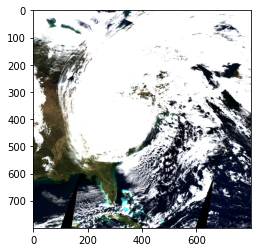

In [1]:
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt


def getTgtArea(rgb, lon, lat, radias):
    n = 3600
    m = 7200
    
    interval = 180.0 / n
    
    lat_index = int((90 - lat) / interval)
    long_index = int((lon + 180) / interval)
    
    n_raidus = int(radias / interval)
    
    
    return rgb[lat_index - n_raidus:lat_index + n_raidus, long_index - n_raidus:long_index + n_raidus]
  

hdf = SD('/home/fun/scripts/MOD09CMG.A2012304.006.2015251060001.hdf') # first day of hurricane sandy

for it in hdf.datasets():
    print (it)


R = hdf.select('Coarse Resolution Surface Reflectance Band 1').get()
B = hdf.select('Coarse Resolution Surface Reflectance Band 3').get()
G = hdf.select('Coarse Resolution Surface Reflectance Band 4').get()



R_true = R * 0.0004
G_true = G * 0.0004
B_true = B * 0.0004

rgb = np.dstack([R_true, G_true, B_true])

print (B.shape)


#top-left -180LONG, 90LAT



plt.figure()
plt.imshow(getTgtArea(rgb, -75.4, 40.3, 20))
#plt.imshow(rgb)
#plt.imshow(T20)

plt.show()





(3600, 7200)


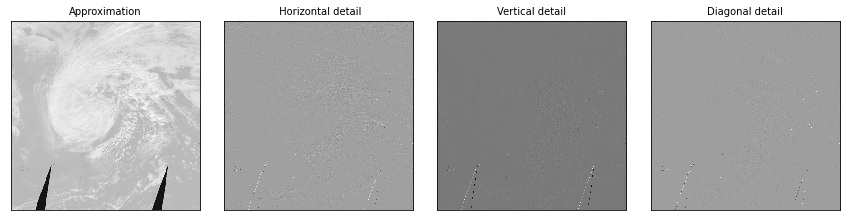

In [91]:
import pywt
print(R.shape)
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
R_coeffs2 = pywt.dwt2(getTgtArea(R, -75.4, 40.3, 20), 'bior1.3')
G_coeffs2 = pywt.dwt2(getTgtArea(G, -75.4, 40.3, 20), 'bior1.3')
B_coeffs2 = pywt.dwt2(getTgtArea(B, -75.4, 40.3, 20), 'bior1.3')


R_LL, (R_LH, R_HL, R_HH) = R_coeffs2
G_LL, (G_LH, G_HL, G_HH) = G_coeffs2
B_LL, (B_LH, B_HL, B_HH) = B_coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([R_LL, R_LH, R_HL, R_HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



In [9]:
# test function

import matplotlib.pyplot as plt
import pywt
import numpy as np
import glob

def biorthogonal_DWT_modis(full_list):
    
    for index in full_list:

        name = index + '10_modis*.npy'
        modis_files = glob.glob(name, recursive = True)
        
        if len(modis_files) == 0:
            continue
        
        for file in modis_files:
            print(name, file)

            rgb = np.load(file)

            R_coeffs2 = pywt.dwt2(rgb[:, :, 0], 'bior1.3')
            G_coeffs2 = pywt.dwt2(rgb[:, :, 1], 'bior1.3')
            B_coeffs2 = pywt.dwt2(rgb[:, :, 2], 'bior1.3')

            R_LL, (R_LH, R_HL, R_HH) = R_coeffs2
            G_LL, (G_LH, G_HL, G_HH) = G_coeffs2
            B_LL, (B_LH, B_HL, B_HH) = B_coeffs2

            final = np.asarray([R_LL, R_LH, R_HL, R_HH, G_LL, G_LH, G_HL, G_HH, B_LL, B_LH, B_HL, B_HH])

            date = file[-12:-4]

            filename = index + '10_wavelet_rgb_' + date + '.npy'
            print(filename)
            print(final.shape)
            np.save(filename, final)
    
    return final



In [11]:
folder_list = glob.glob('/home/fun/data/AL*20*/')

biorthogonal_DWT_modis(folder_list)

/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040803.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040803.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040804.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040804.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040805.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040805.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040806.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040806.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040807.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040807.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.npy /home/fun/data/AL022004/10_modis_satellite_20040808.npy
/home/fun/data/AL022004/10_wavelet_rgb_20040808.npy
(12, 202, 202)
/home/fun/data/AL022004/10_modis*.

/home/fun/data/AL072006/10_wavelet_rgb_20060908.npy
(12, 202, 202)
/home/fun/data/AL072006/10_modis*.npy /home/fun/data/AL072006/10_modis_satellite_20060909.npy
/home/fun/data/AL072006/10_wavelet_rgb_20060909.npy
(12, 202, 202)
/home/fun/data/AL072006/10_modis*.npy /home/fun/data/AL072006/10_modis_satellite_20060910.npy
/home/fun/data/AL072006/10_wavelet_rgb_20060910.npy
(12, 202, 202)
/home/fun/data/AL072006/10_modis*.npy /home/fun/data/AL072006/10_modis_satellite_20060911.npy
/home/fun/data/AL072006/10_wavelet_rgb_20060911.npy
(12, 202, 202)
/home/fun/data/AL012000/10_modis*.npy /home/fun/data/AL012000/10_modis_satellite_20000607.npy
/home/fun/data/AL012000/10_wavelet_rgb_20000607.npy
(12, 202, 202)
/home/fun/data/AL012000/10_modis*.npy /home/fun/data/AL012000/10_modis_satellite_20000608.npy
/home/fun/data/AL012000/10_wavelet_rgb_20000608.npy
(12, 202, 202)
/home/fun/data/AL022000/10_modis*.npy /home/fun/data/AL022000/10_modis_satellite_20000623.npy
/home/fun/data/AL022000/10_wavelet

/home/fun/data/AL122000/10_wavelet_rgb_20000922.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000921.npy
/home/fun/data/AL132000/10_wavelet_rgb_20000921.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000922.npy
/home/fun/data/AL132000/10_wavelet_rgb_20000922.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000923.npy
/home/fun/data/AL132000/10_wavelet_rgb_20000923.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000924.npy
/home/fun/data/AL132000/10_wavelet_rgb_20000924.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000925.npy
/home/fun/data/AL132000/10_wavelet_rgb_20000925.npy
(12, 202, 202)
/home/fun/data/AL132000/10_modis*.npy /home/fun/data/AL132000/10_modis_satellite_20000926.npy
/home/fun/data/AL132000/10_wavelet

/home/fun/data/AL032001/10_wavelet_rgb_20010803.npy
(12, 202, 202)
/home/fun/data/AL032001/10_modis*.npy /home/fun/data/AL032001/10_modis_satellite_20010804.npy
/home/fun/data/AL032001/10_wavelet_rgb_20010804.npy
(12, 202, 202)
/home/fun/data/AL032001/10_modis*.npy /home/fun/data/AL032001/10_modis_satellite_20010805.npy
/home/fun/data/AL032001/10_wavelet_rgb_20010805.npy
(12, 202, 202)
/home/fun/data/AL032001/10_modis*.npy /home/fun/data/AL032001/10_modis_satellite_20010806.npy
/home/fun/data/AL032001/10_wavelet_rgb_20010806.npy
(12, 202, 202)
/home/fun/data/AL032001/10_modis*.npy /home/fun/data/AL032001/10_modis_satellite_20010802.npy
/home/fun/data/AL032001/10_wavelet_rgb_20010802.npy
(12, 202, 202)
/home/fun/data/AL042001/10_modis*.npy /home/fun/data/AL042001/10_modis_satellite_20010814.npy
/home/fun/data/AL042001/10_wavelet_rgb_20010814.npy
(12, 202, 202)
/home/fun/data/AL042001/10_modis*.npy /home/fun/data/AL042001/10_modis_satellite_20010815.npy
/home/fun/data/AL042001/10_wavelet

/home/fun/data/AL082001/10_wavelet_rgb_20010912.npy
(12, 202, 202)
/home/fun/data/AL082001/10_modis*.npy /home/fun/data/AL082001/10_modis_satellite_20010913.npy
/home/fun/data/AL082001/10_wavelet_rgb_20010913.npy
(12, 202, 202)
/home/fun/data/AL082001/10_modis*.npy /home/fun/data/AL082001/10_modis_satellite_20010914.npy
/home/fun/data/AL082001/10_wavelet_rgb_20010914.npy
(12, 202, 202)
/home/fun/data/AL092001/10_modis*.npy /home/fun/data/AL092001/10_modis_satellite_20010919.npy
/home/fun/data/AL092001/10_wavelet_rgb_20010919.npy
(12, 202, 202)
/home/fun/data/AL102001/10_modis*.npy /home/fun/data/AL102001/10_modis_satellite_20010922.npy
/home/fun/data/AL102001/10_wavelet_rgb_20010922.npy
(12, 202, 202)
/home/fun/data/AL102001/10_modis*.npy /home/fun/data/AL102001/10_modis_satellite_20010921.npy
/home/fun/data/AL102001/10_wavelet_rgb_20010921.npy
(12, 202, 202)
/home/fun/data/AL102001/10_modis*.npy /home/fun/data/AL102001/10_modis_satellite_20010923.npy
/home/fun/data/AL102001/10_wavelet

/home/fun/data/AL172001/10_wavelet_rgb_20011202.npy
(12, 202, 202)
/home/fun/data/AL172001/10_modis*.npy /home/fun/data/AL172001/10_modis_satellite_20011203.npy
/home/fun/data/AL172001/10_wavelet_rgb_20011203.npy
(12, 202, 202)
/home/fun/data/AL172001/10_modis*.npy /home/fun/data/AL172001/10_modis_satellite_20011204.npy
/home/fun/data/AL172001/10_wavelet_rgb_20011204.npy
(12, 202, 202)
/home/fun/data/AL012002/10_modis*.npy /home/fun/data/AL012002/10_modis_satellite_20020715.npy
/home/fun/data/AL012002/10_wavelet_rgb_20020715.npy
(12, 202, 202)
/home/fun/data/AL012002/10_modis*.npy /home/fun/data/AL012002/10_modis_satellite_20020714.npy
/home/fun/data/AL012002/10_wavelet_rgb_20020714.npy
(12, 202, 202)
/home/fun/data/AL012002/10_modis*.npy /home/fun/data/AL012002/10_modis_satellite_20020719.npy
/home/fun/data/AL012002/10_wavelet_rgb_20020719.npy
(12, 202, 202)
/home/fun/data/AL012002/10_modis*.npy /home/fun/data/AL012002/10_modis_satellite_20020716.npy
/home/fun/data/AL012002/10_wavelet

/home/fun/data/AL122002/10_wavelet_rgb_20020921.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020922.npy
/home/fun/data/AL122002/10_wavelet_rgb_20020922.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020923.npy
/home/fun/data/AL122002/10_wavelet_rgb_20020923.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020924.npy
/home/fun/data/AL122002/10_wavelet_rgb_20020924.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020925.npy
/home/fun/data/AL122002/10_wavelet_rgb_20020925.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020926.npy
/home/fun/data/AL122002/10_wavelet_rgb_20020926.npy
(12, 202, 202)
/home/fun/data/AL122002/10_modis*.npy /home/fun/data/AL122002/10_modis_satellite_20020927.npy
/home/fun/data/AL122002/10_wavelet

/home/fun/data/AL042003/10_wavelet_rgb_20030710.npy
(12, 202, 202)
/home/fun/data/AL042003/10_modis*.npy /home/fun/data/AL042003/10_modis_satellite_20030711.npy
/home/fun/data/AL042003/10_wavelet_rgb_20030711.npy
(12, 202, 202)
/home/fun/data/AL052003/10_modis*.npy /home/fun/data/AL052003/10_modis_satellite_20030716.npy
/home/fun/data/AL052003/10_wavelet_rgb_20030716.npy
(12, 202, 202)
/home/fun/data/AL052003/10_modis*.npy /home/fun/data/AL052003/10_modis_satellite_20030717.npy
/home/fun/data/AL052003/10_wavelet_rgb_20030717.npy
(12, 202, 202)
/home/fun/data/AL052003/10_modis*.npy /home/fun/data/AL052003/10_modis_satellite_20030718.npy
/home/fun/data/AL052003/10_wavelet_rgb_20030718.npy
(12, 202, 202)
/home/fun/data/AL052003/10_modis*.npy /home/fun/data/AL052003/10_modis_satellite_20030719.npy
/home/fun/data/AL052003/10_wavelet_rgb_20030719.npy
(12, 202, 202)
/home/fun/data/AL052003/10_modis*.npy /home/fun/data/AL052003/10_modis_satellite_20030720.npy
/home/fun/data/AL052003/10_wavelet

/home/fun/data/AL132003/10_wavelet_rgb_20030913.npy
(12, 202, 202)
/home/fun/data/AL132003/10_modis*.npy /home/fun/data/AL132003/10_modis_satellite_20030914.npy
/home/fun/data/AL132003/10_wavelet_rgb_20030914.npy
(12, 202, 202)
/home/fun/data/AL132003/10_modis*.npy /home/fun/data/AL132003/10_modis_satellite_20030915.npy
/home/fun/data/AL132003/10_wavelet_rgb_20030915.npy
(12, 202, 202)
/home/fun/data/AL132003/10_modis*.npy /home/fun/data/AL132003/10_modis_satellite_20030916.npy
/home/fun/data/AL132003/10_wavelet_rgb_20030916.npy
(12, 202, 202)
/home/fun/data/AL132003/10_modis*.npy /home/fun/data/AL132003/10_modis_satellite_20030917.npy
/home/fun/data/AL132003/10_wavelet_rgb_20030917.npy
(12, 202, 202)
/home/fun/data/AL132003/10_modis*.npy /home/fun/data/AL132003/10_modis_satellite_20030918.npy
/home/fun/data/AL132003/10_wavelet_rgb_20030918.npy
(12, 202, 202)
/home/fun/data/AL142003/10_modis*.npy /home/fun/data/AL142003/10_modis_satellite_20030908.npy
/home/fun/data/AL142003/10_wavelet

/home/fun/data/AL192003/10_wavelet_rgb_20031020.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031021.npy
/home/fun/data/AL192003/10_wavelet_rgb_20031021.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031022.npy
/home/fun/data/AL192003/10_wavelet_rgb_20031022.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031023.npy
/home/fun/data/AL192003/10_wavelet_rgb_20031023.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031024.npy
/home/fun/data/AL192003/10_wavelet_rgb_20031024.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031025.npy
/home/fun/data/AL192003/10_wavelet_rgb_20031025.npy
(12, 202, 202)
/home/fun/data/AL192003/10_modis*.npy /home/fun/data/AL192003/10_modis_satellite_20031026.npy
/home/fun/data/AL192003/10_wavelet

/home/fun/data/AL092004/10_wavelet_rgb_20040907.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040908.npy
/home/fun/data/AL092004/10_wavelet_rgb_20040908.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040909.npy
/home/fun/data/AL092004/10_wavelet_rgb_20040909.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040910.npy
/home/fun/data/AL092004/10_wavelet_rgb_20040910.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040911.npy
/home/fun/data/AL092004/10_wavelet_rgb_20040911.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040912.npy
/home/fun/data/AL092004/10_wavelet_rgb_20040912.npy
(12, 202, 202)
/home/fun/data/AL092004/10_modis*.npy /home/fun/data/AL092004/10_modis_satellite_20040913.npy
/home/fun/data/AL092004/10_wavelet

/home/fun/data/AL012005/10_modis*.npy /home/fun/data/AL012005/10_modis_satellite_20050608.npy
/home/fun/data/AL012005/10_wavelet_rgb_20050608.npy
(12, 202, 202)
/home/fun/data/AL012005/10_modis*.npy /home/fun/data/AL012005/10_modis_satellite_20050610.npy
/home/fun/data/AL012005/10_wavelet_rgb_20050610.npy
(12, 202, 202)
/home/fun/data/AL012005/10_modis*.npy /home/fun/data/AL012005/10_modis_satellite_20050611.npy
/home/fun/data/AL012005/10_wavelet_rgb_20050611.npy
(12, 202, 202)
/home/fun/data/AL022005/10_modis*.npy /home/fun/data/AL022005/10_modis_satellite_20050628.npy
/home/fun/data/AL022005/10_wavelet_rgb_20050628.npy
(12, 202, 202)
/home/fun/data/AL022005/10_modis*.npy /home/fun/data/AL022005/10_modis_satellite_20050629.npy
/home/fun/data/AL022005/10_wavelet_rgb_20050629.npy
(12, 202, 202)
/home/fun/data/AL032005/10_modis*.npy /home/fun/data/AL032005/10_modis_satellite_20050703.npy
/home/fun/data/AL032005/10_wavelet_rgb_20050703.npy
(12, 202, 202)
/home/fun/data/AL032005/10_modis*.

/home/fun/data/AL092005/10_wavelet_rgb_20050817.npy
(12, 202, 202)
/home/fun/data/AL092005/10_modis*.npy /home/fun/data/AL092005/10_modis_satellite_20050818.npy
/home/fun/data/AL092005/10_wavelet_rgb_20050818.npy
(12, 202, 202)
/home/fun/data/AL102005/10_modis*.npy /home/fun/data/AL102005/10_modis_satellite_20050816.npy
/home/fun/data/AL102005/10_wavelet_rgb_20050816.npy
(12, 202, 202)
/home/fun/data/AL102005/10_modis*.npy /home/fun/data/AL102005/10_modis_satellite_20050817.npy
/home/fun/data/AL102005/10_wavelet_rgb_20050817.npy
(12, 202, 202)
/home/fun/data/AL102005/10_modis*.npy /home/fun/data/AL102005/10_modis_satellite_20050818.npy
/home/fun/data/AL102005/10_wavelet_rgb_20050818.npy
(12, 202, 202)
/home/fun/data/AL102005/10_modis*.npy /home/fun/data/AL102005/10_modis_satellite_20050813.npy
/home/fun/data/AL102005/10_wavelet_rgb_20050813.npy
(12, 202, 202)
/home/fun/data/AL102005/10_modis*.npy /home/fun/data/AL102005/10_modis_satellite_20050814.npy
/home/fun/data/AL102005/10_wavelet

/home/fun/data/AL182005/10_wavelet_rgb_20050920.npy
(12, 202, 202)
/home/fun/data/AL182005/10_modis*.npy /home/fun/data/AL182005/10_modis_satellite_20050921.npy
/home/fun/data/AL182005/10_wavelet_rgb_20050921.npy
(12, 202, 202)
/home/fun/data/AL182005/10_modis*.npy /home/fun/data/AL182005/10_modis_satellite_20050922.npy
/home/fun/data/AL182005/10_wavelet_rgb_20050922.npy
(12, 202, 202)
/home/fun/data/AL182005/10_modis*.npy /home/fun/data/AL182005/10_modis_satellite_20050924.npy
/home/fun/data/AL182005/10_wavelet_rgb_20050924.npy
(12, 202, 202)
/home/fun/data/AL192005/10_modis*.npy /home/fun/data/AL192005/10_modis_satellite_20050930.npy
/home/fun/data/AL192005/10_wavelet_rgb_20050930.npy
(12, 202, 202)
/home/fun/data/AL192005/10_modis*.npy /home/fun/data/AL192005/10_modis_satellite_20051001.npy
/home/fun/data/AL192005/10_wavelet_rgb_20051001.npy
(12, 202, 202)
/home/fun/data/AL192005/10_modis*.npy /home/fun/data/AL192005/10_modis_satellite_20051002.npy
/home/fun/data/AL192005/10_wavelet

/home/fun/data/AL292005/10_wavelet_rgb_20051125.npy
(12, 202, 202)
/home/fun/data/AL292005/10_modis*.npy /home/fun/data/AL292005/10_modis_satellite_20051126.npy
/home/fun/data/AL292005/10_wavelet_rgb_20051126.npy
(12, 202, 202)
/home/fun/data/AL292005/10_modis*.npy /home/fun/data/AL292005/10_modis_satellite_20051127.npy
/home/fun/data/AL292005/10_wavelet_rgb_20051127.npy
(12, 202, 202)
/home/fun/data/AL292005/10_modis*.npy /home/fun/data/AL292005/10_modis_satellite_20051128.npy
/home/fun/data/AL292005/10_wavelet_rgb_20051128.npy
(12, 202, 202)
/home/fun/data/AL292005/10_modis*.npy /home/fun/data/AL292005/10_modis_satellite_20051129.npy
/home/fun/data/AL292005/10_wavelet_rgb_20051129.npy
(12, 202, 202)
/home/fun/data/AL302005/10_modis*.npy /home/fun/data/AL302005/10_modis_satellite_20051129.npy
/home/fun/data/AL302005/10_wavelet_rgb_20051129.npy
(12, 202, 202)
/home/fun/data/AL302005/10_modis*.npy /home/fun/data/AL302005/10_modis_satellite_20051130.npy
/home/fun/data/AL302005/10_wavelet

/home/fun/data/AL082006/10_wavelet_rgb_20060918.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060919.npy
/home/fun/data/AL082006/10_wavelet_rgb_20060919.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060920.npy
/home/fun/data/AL082006/10_wavelet_rgb_20060920.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060921.npy
/home/fun/data/AL082006/10_wavelet_rgb_20060921.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060922.npy
/home/fun/data/AL082006/10_wavelet_rgb_20060922.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060923.npy
/home/fun/data/AL082006/10_wavelet_rgb_20060923.npy
(12, 202, 202)
/home/fun/data/AL082006/10_modis*.npy /home/fun/data/AL082006/10_modis_satellite_20060924.npy
/home/fun/data/AL082006/10_wavelet

/home/fun/data/AL042007/10_wavelet_rgb_20070817.npy
(12, 202, 202)
/home/fun/data/AL042007/10_modis*.npy /home/fun/data/AL042007/10_modis_satellite_20070818.npy
/home/fun/data/AL042007/10_wavelet_rgb_20070818.npy
(12, 202, 202)
/home/fun/data/AL042007/10_modis*.npy /home/fun/data/AL042007/10_modis_satellite_20070819.npy
/home/fun/data/AL042007/10_wavelet_rgb_20070819.npy
(12, 202, 202)
/home/fun/data/AL042007/10_modis*.npy /home/fun/data/AL042007/10_modis_satellite_20070820.npy
/home/fun/data/AL042007/10_wavelet_rgb_20070820.npy
(12, 202, 202)
/home/fun/data/AL042007/10_modis*.npy /home/fun/data/AL042007/10_modis_satellite_20070821.npy
/home/fun/data/AL042007/10_wavelet_rgb_20070821.npy
(12, 202, 202)
/home/fun/data/AL052007/10_modis*.npy /home/fun/data/AL052007/10_modis_satellite_20070816.npy
/home/fun/data/AL052007/10_wavelet_rgb_20070816.npy
(12, 202, 202)
/home/fun/data/AL052007/10_modis*.npy /home/fun/data/AL052007/10_modis_satellite_20070815.npy
/home/fun/data/AL052007/10_wavelet

/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071030.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071030.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071031.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071031.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071101.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071101.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071102.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071102.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071103.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071103.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.npy /home/fun/data/AL162007/10_modis_satellite_20071104.npy
/home/fun/data/AL162007/10_wavelet_rgb_20071104.npy
(12, 202, 202)
/home/fun/data/AL162007/10_modis*.

/home/fun/data/AL072008/10_wavelet_rgb_20080826.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080827.npy
/home/fun/data/AL072008/10_wavelet_rgb_20080827.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080828.npy
/home/fun/data/AL072008/10_wavelet_rgb_20080828.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080829.npy
/home/fun/data/AL072008/10_wavelet_rgb_20080829.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080830.npy
/home/fun/data/AL072008/10_wavelet_rgb_20080830.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080831.npy
/home/fun/data/AL072008/10_wavelet_rgb_20080831.npy
(12, 202, 202)
/home/fun/data/AL072008/10_modis*.npy /home/fun/data/AL072008/10_modis_satellite_20080901.npy
/home/fun/data/AL072008/10_wavelet

/home/fun/data/AL132008/10_wavelet_rgb_20081006.npy
(12, 202, 202)
/home/fun/data/AL132008/10_modis*.npy /home/fun/data/AL132008/10_modis_satellite_20081007.npy
/home/fun/data/AL132008/10_wavelet_rgb_20081007.npy
(12, 202, 202)
/home/fun/data/AL142008/10_modis*.npy /home/fun/data/AL142008/10_modis_satellite_20081012.npy
/home/fun/data/AL142008/10_wavelet_rgb_20081012.npy
(12, 202, 202)
/home/fun/data/AL142008/10_modis*.npy /home/fun/data/AL142008/10_modis_satellite_20081013.npy
/home/fun/data/AL142008/10_wavelet_rgb_20081013.npy
(12, 202, 202)
/home/fun/data/AL142008/10_modis*.npy /home/fun/data/AL142008/10_modis_satellite_20081014.npy
/home/fun/data/AL142008/10_wavelet_rgb_20081014.npy
(12, 202, 202)
/home/fun/data/AL142008/10_modis*.npy /home/fun/data/AL142008/10_modis_satellite_20081015.npy
/home/fun/data/AL142008/10_wavelet_rgb_20081015.npy
(12, 202, 202)
/home/fun/data/AL152008/10_modis*.npy /home/fun/data/AL152008/10_modis_satellite_20081013.npy
/home/fun/data/AL152008/10_wavelet

/home/fun/data/AL052009/10_modis*.npy /home/fun/data/AL052009/10_modis_satellite_20090829.npy
/home/fun/data/AL052009/10_wavelet_rgb_20090829.npy
(12, 202, 202)
/home/fun/data/AL062009/10_modis*.npy /home/fun/data/AL062009/10_modis_satellite_20090901.npy
/home/fun/data/AL062009/10_wavelet_rgb_20090901.npy
(12, 202, 202)
/home/fun/data/AL062009/10_modis*.npy /home/fun/data/AL062009/10_modis_satellite_20090902.npy
/home/fun/data/AL062009/10_wavelet_rgb_20090902.npy
(12, 202, 202)
/home/fun/data/AL072009/10_modis*.npy /home/fun/data/AL072009/10_modis_satellite_20090907.npy
/home/fun/data/AL072009/10_wavelet_rgb_20090907.npy
(12, 202, 202)
/home/fun/data/AL072009/10_modis*.npy /home/fun/data/AL072009/10_modis_satellite_20090908.npy
/home/fun/data/AL072009/10_wavelet_rgb_20090908.npy
(12, 202, 202)
/home/fun/data/AL072009/10_modis*.npy /home/fun/data/AL072009/10_modis_satellite_20090909.npy
/home/fun/data/AL072009/10_wavelet_rgb_20090909.npy
(12, 202, 202)
/home/fun/data/AL072009/10_modis*.

/home/fun/data/AL052010/10_wavelet_rgb_20100812.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100813.npy
/home/fun/data/AL052010/10_wavelet_rgb_20100813.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100814.npy
/home/fun/data/AL052010/10_wavelet_rgb_20100814.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100815.npy
/home/fun/data/AL052010/10_wavelet_rgb_20100815.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100816.npy
/home/fun/data/AL052010/10_wavelet_rgb_20100816.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100817.npy
/home/fun/data/AL052010/10_wavelet_rgb_20100817.npy
(12, 202, 202)
/home/fun/data/AL052010/10_modis*.npy /home/fun/data/AL052010/10_modis_satellite_20100818.npy
/home/fun/data/AL052010/10_wavelet

/home/fun/data/AL112010/10_wavelet_rgb_20100919.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100920.npy
/home/fun/data/AL112010/10_wavelet_rgb_20100920.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100921.npy
/home/fun/data/AL112010/10_wavelet_rgb_20100921.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100908.npy
/home/fun/data/AL112010/10_wavelet_rgb_20100908.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100909.npy
/home/fun/data/AL112010/10_wavelet_rgb_20100909.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100910.npy
/home/fun/data/AL112010/10_wavelet_rgb_20100910.npy
(12, 202, 202)
/home/fun/data/AL112010/10_modis*.npy /home/fun/data/AL112010/10_modis_satellite_20100911.npy
/home/fun/data/AL112010/10_wavelet

/home/fun/data/AL172010/10_wavelet_rgb_20101016.npy
(12, 202, 202)
/home/fun/data/AL172010/10_modis*.npy /home/fun/data/AL172010/10_modis_satellite_20101017.npy
/home/fun/data/AL172010/10_wavelet_rgb_20101017.npy
(12, 202, 202)
/home/fun/data/AL182010/10_modis*.npy /home/fun/data/AL182010/10_modis_satellite_20101011.npy
/home/fun/data/AL182010/10_wavelet_rgb_20101011.npy
(12, 202, 202)
/home/fun/data/AL192010/10_modis*.npy /home/fun/data/AL192010/10_modis_satellite_20101020.npy
/home/fun/data/AL192010/10_wavelet_rgb_20101020.npy
(12, 202, 202)
/home/fun/data/AL192010/10_modis*.npy /home/fun/data/AL192010/10_modis_satellite_20101019.npy
/home/fun/data/AL192010/10_wavelet_rgb_20101019.npy
(12, 202, 202)
/home/fun/data/AL192010/10_modis*.npy /home/fun/data/AL192010/10_modis_satellite_20101021.npy
/home/fun/data/AL192010/10_wavelet_rgb_20101021.npy
(12, 202, 202)
/home/fun/data/AL192010/10_modis*.npy /home/fun/data/AL192010/10_modis_satellite_20101022.npy
/home/fun/data/AL192010/10_wavelet

/home/fun/data/AL082011/10_wavelet_rgb_20110820.npy
(12, 202, 202)
/home/fun/data/AL092011/10_modis*.npy /home/fun/data/AL092011/10_modis_satellite_20110821.npy
/home/fun/data/AL092011/10_wavelet_rgb_20110821.npy
(12, 202, 202)
/home/fun/data/AL102011/10_modis*.npy /home/fun/data/AL102011/10_modis_satellite_20110825.npy
/home/fun/data/AL102011/10_wavelet_rgb_20110825.npy
(12, 202, 202)
/home/fun/data/AL102011/10_modis*.npy /home/fun/data/AL102011/10_modis_satellite_20110826.npy
/home/fun/data/AL102011/10_wavelet_rgb_20110826.npy
(12, 202, 202)
/home/fun/data/AL102011/10_modis*.npy /home/fun/data/AL102011/10_modis_satellite_20110827.npy
/home/fun/data/AL102011/10_wavelet_rgb_20110827.npy
(12, 202, 202)
/home/fun/data/AL112011/10_modis*.npy /home/fun/data/AL112011/10_modis_satellite_20110826.npy
/home/fun/data/AL112011/10_wavelet_rgb_20110826.npy
(12, 202, 202)
/home/fun/data/AL112011/10_modis*.npy /home/fun/data/AL112011/10_modis_satellite_20110827.npy
/home/fun/data/AL112011/10_wavelet

/home/fun/data/AL162011/10_wavelet_rgb_20110921.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110922.npy
/home/fun/data/AL162011/10_wavelet_rgb_20110922.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110923.npy
/home/fun/data/AL162011/10_wavelet_rgb_20110923.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110924.npy
/home/fun/data/AL162011/10_wavelet_rgb_20110924.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110925.npy
/home/fun/data/AL162011/10_wavelet_rgb_20110925.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110926.npy
/home/fun/data/AL162011/10_wavelet_rgb_20110926.npy
(12, 202, 202)
/home/fun/data/AL162011/10_modis*.npy /home/fun/data/AL162011/10_modis_satellite_20110927.npy
/home/fun/data/AL162011/10_wavelet

/home/fun/data/AL022012/10_wavelet_rgb_20120527.npy
(12, 202, 202)
/home/fun/data/AL022012/10_modis*.npy /home/fun/data/AL022012/10_modis_satellite_20120528.npy
/home/fun/data/AL022012/10_wavelet_rgb_20120528.npy
(12, 202, 202)
/home/fun/data/AL032012/10_modis*.npy /home/fun/data/AL032012/10_modis_satellite_20120618.npy
/home/fun/data/AL032012/10_wavelet_rgb_20120618.npy
(12, 202, 202)
/home/fun/data/AL032012/10_modis*.npy /home/fun/data/AL032012/10_modis_satellite_20120617.npy
/home/fun/data/AL032012/10_wavelet_rgb_20120617.npy
(12, 202, 202)
/home/fun/data/AL032012/10_modis*.npy /home/fun/data/AL032012/10_modis_satellite_20120619.npy
/home/fun/data/AL032012/10_wavelet_rgb_20120619.npy
(12, 202, 202)
/home/fun/data/AL032012/10_modis*.npy /home/fun/data/AL032012/10_modis_satellite_20120620.npy
/home/fun/data/AL032012/10_wavelet_rgb_20120620.npy
(12, 202, 202)
/home/fun/data/AL032012/10_modis*.npy /home/fun/data/AL032012/10_modis_satellite_20120621.npy
/home/fun/data/AL032012/10_wavelet

/home/fun/data/AL102012/10_wavelet_rgb_20120821.npy
(12, 202, 202)
/home/fun/data/AL102012/10_modis*.npy /home/fun/data/AL102012/10_modis_satellite_20120822.npy
/home/fun/data/AL102012/10_wavelet_rgb_20120822.npy
(12, 202, 202)
/home/fun/data/AL102012/10_modis*.npy /home/fun/data/AL102012/10_modis_satellite_20120823.npy
/home/fun/data/AL102012/10_wavelet_rgb_20120823.npy
(12, 202, 202)
/home/fun/data/AL102012/10_modis*.npy /home/fun/data/AL102012/10_modis_satellite_20120824.npy
/home/fun/data/AL102012/10_wavelet_rgb_20120824.npy
(12, 202, 202)
/home/fun/data/AL112012/10_modis*.npy /home/fun/data/AL112012/10_modis_satellite_20120830.npy
/home/fun/data/AL112012/10_wavelet_rgb_20120830.npy
(12, 202, 202)
/home/fun/data/AL112012/10_modis*.npy /home/fun/data/AL112012/10_modis_satellite_20120831.npy
/home/fun/data/AL112012/10_wavelet_rgb_20120831.npy
(12, 202, 202)
/home/fun/data/AL112012/10_modis*.npy /home/fun/data/AL112012/10_modis_satellite_20120901.npy
/home/fun/data/AL112012/10_wavelet

/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120925.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120925.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120926.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120926.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120927.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120927.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120928.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120928.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120929.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120929.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.npy /home/fun/data/AL142012/10_modis_satellite_20120930.npy
/home/fun/data/AL142012/10_wavelet_rgb_20120930.npy
(12, 202, 202)
/home/fun/data/AL142012/10_modis*.

/home/fun/data/AL032013/10_wavelet_rgb_20130707.npy
(12, 202, 202)
/home/fun/data/AL032013/10_modis*.npy /home/fun/data/AL032013/10_modis_satellite_20130708.npy
/home/fun/data/AL032013/10_wavelet_rgb_20130708.npy
(12, 202, 202)
/home/fun/data/AL032013/10_modis*.npy /home/fun/data/AL032013/10_modis_satellite_20130709.npy
/home/fun/data/AL032013/10_wavelet_rgb_20130709.npy
(12, 202, 202)
/home/fun/data/AL032013/10_modis*.npy /home/fun/data/AL032013/10_modis_satellite_20130710.npy
/home/fun/data/AL032013/10_wavelet_rgb_20130710.npy
(12, 202, 202)
/home/fun/data/AL042013/10_modis*.npy /home/fun/data/AL042013/10_modis_satellite_20130722.npy
/home/fun/data/AL042013/10_wavelet_rgb_20130722.npy
(12, 202, 202)
/home/fun/data/AL042013/10_modis*.npy /home/fun/data/AL042013/10_modis_satellite_20130723.npy
/home/fun/data/AL042013/10_wavelet_rgb_20130723.npy
(12, 202, 202)
/home/fun/data/AL042013/10_modis*.npy /home/fun/data/AL042013/10_modis_satellite_20130724.npy
/home/fun/data/AL042013/10_wavelet

/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20130929.npy
/home/fun/data/AL112013/10_wavelet_rgb_20130929.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20130928.npy
/home/fun/data/AL112013/10_wavelet_rgb_20130928.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20130930.npy
/home/fun/data/AL112013/10_wavelet_rgb_20130930.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20131001.npy
/home/fun/data/AL112013/10_wavelet_rgb_20131001.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20131002.npy
/home/fun/data/AL112013/10_wavelet_rgb_20131002.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.npy /home/fun/data/AL112013/10_modis_satellite_20131003.npy
/home/fun/data/AL112013/10_wavelet_rgb_20131003.npy
(12, 202, 202)
/home/fun/data/AL112013/10_modis*.

/home/fun/data/AL032014/10_wavelet_rgb_20140807.npy
(12, 202, 202)
/home/fun/data/AL032014/10_modis*.npy /home/fun/data/AL032014/10_modis_satellite_20140808.npy
/home/fun/data/AL032014/10_wavelet_rgb_20140808.npy
(12, 202, 202)
/home/fun/data/AL032014/10_modis*.npy /home/fun/data/AL032014/10_modis_satellite_20140809.npy
/home/fun/data/AL032014/10_wavelet_rgb_20140809.npy
(12, 202, 202)
/home/fun/data/AL042014/10_modis*.npy /home/fun/data/AL042014/10_modis_satellite_20140823.npy
/home/fun/data/AL042014/10_wavelet_rgb_20140823.npy
(12, 202, 202)
/home/fun/data/AL042014/10_modis*.npy /home/fun/data/AL042014/10_modis_satellite_20140824.npy
/home/fun/data/AL042014/10_wavelet_rgb_20140824.npy
(12, 202, 202)
/home/fun/data/AL042014/10_modis*.npy /home/fun/data/AL042014/10_modis_satellite_20140825.npy
/home/fun/data/AL042014/10_wavelet_rgb_20140825.npy
(12, 202, 202)
/home/fun/data/AL042014/10_modis*.npy /home/fun/data/AL042014/10_modis_satellite_20140826.npy
/home/fun/data/AL042014/10_wavelet

/home/fun/data/AL042015/10_wavelet_rgb_20150817.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150818.npy
/home/fun/data/AL042015/10_wavelet_rgb_20150818.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150819.npy
/home/fun/data/AL042015/10_wavelet_rgb_20150819.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150820.npy
/home/fun/data/AL042015/10_wavelet_rgb_20150820.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150821.npy
/home/fun/data/AL042015/10_wavelet_rgb_20150821.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150822.npy
/home/fun/data/AL042015/10_wavelet_rgb_20150822.npy
(12, 202, 202)
/home/fun/data/AL042015/10_modis*.npy /home/fun/data/AL042015/10_modis_satellite_20150823.npy
/home/fun/data/AL042015/10_wavelet

/home/fun/data/AL112015/10_wavelet_rgb_20151003.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151004.npy
/home/fun/data/AL112015/10_wavelet_rgb_20151004.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151005.npy
/home/fun/data/AL112015/10_wavelet_rgb_20151005.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151006.npy
/home/fun/data/AL112015/10_wavelet_rgb_20151006.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151007.npy
/home/fun/data/AL112015/10_wavelet_rgb_20151007.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151008.npy
/home/fun/data/AL112015/10_wavelet_rgb_20151008.npy
(12, 202, 202)
/home/fun/data/AL112015/10_modis*.npy /home/fun/data/AL112015/10_modis_satellite_20151009.npy
/home/fun/data/AL112015/10_wavelet

/home/fun/data/AL072016/10_wavelet_rgb_20160821.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160822.npy
/home/fun/data/AL072016/10_wavelet_rgb_20160822.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160823.npy
/home/fun/data/AL072016/10_wavelet_rgb_20160823.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160824.npy
/home/fun/data/AL072016/10_wavelet_rgb_20160824.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160825.npy
/home/fun/data/AL072016/10_wavelet_rgb_20160825.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160826.npy
/home/fun/data/AL072016/10_wavelet_rgb_20160826.npy
(12, 202, 202)
/home/fun/data/AL072016/10_modis*.npy /home/fun/data/AL072016/10_modis_satellite_20160827.npy
/home/fun/data/AL072016/10_wavelet

/home/fun/data/AL122016/10_wavelet_rgb_20160923.npy
(12, 202, 202)
/home/fun/data/AL122016/10_modis*.npy /home/fun/data/AL122016/10_modis_satellite_20160924.npy
/home/fun/data/AL122016/10_wavelet_rgb_20160924.npy
(12, 202, 202)
/home/fun/data/AL122016/10_modis*.npy /home/fun/data/AL122016/10_modis_satellite_20160925.npy
/home/fun/data/AL122016/10_wavelet_rgb_20160925.npy
(12, 202, 202)
/home/fun/data/AL122016/10_modis*.npy /home/fun/data/AL122016/10_modis_satellite_20160926.npy
/home/fun/data/AL122016/10_wavelet_rgb_20160926.npy
(12, 202, 202)
/home/fun/data/AL132016/10_modis*.npy /home/fun/data/AL132016/10_modis_satellite_20160920.npy
/home/fun/data/AL132016/10_wavelet_rgb_20160920.npy
(12, 202, 202)
/home/fun/data/AL132016/10_modis*.npy /home/fun/data/AL132016/10_modis_satellite_20160919.npy
/home/fun/data/AL132016/10_wavelet_rgb_20160919.npy
(12, 202, 202)
/home/fun/data/AL132016/10_modis*.npy /home/fun/data/AL132016/10_modis_satellite_20160921.npy
/home/fun/data/AL132016/10_wavelet

/home/fun/data/AL012017/10_wavelet_rgb_20170422.npy
(12, 202, 202)
/home/fun/data/AL022017/10_modis*.npy /home/fun/data/AL022017/10_modis_satellite_20170618.npy
/home/fun/data/AL022017/10_wavelet_rgb_20170618.npy
(12, 202, 202)
/home/fun/data/AL022017/10_modis*.npy /home/fun/data/AL022017/10_modis_satellite_20170619.npy
/home/fun/data/AL022017/10_wavelet_rgb_20170619.npy
(12, 202, 202)
/home/fun/data/AL022017/10_modis*.npy /home/fun/data/AL022017/10_modis_satellite_20170620.npy
/home/fun/data/AL022017/10_wavelet_rgb_20170620.npy
(12, 202, 202)
/home/fun/data/AL032017/10_modis*.npy /home/fun/data/AL032017/10_modis_satellite_20170620.npy
/home/fun/data/AL032017/10_wavelet_rgb_20170620.npy
(12, 202, 202)
/home/fun/data/AL032017/10_modis*.npy /home/fun/data/AL032017/10_modis_satellite_20170619.npy
/home/fun/data/AL032017/10_wavelet_rgb_20170619.npy
(12, 202, 202)
/home/fun/data/AL032017/10_modis*.npy /home/fun/data/AL032017/10_modis_satellite_20170621.npy
/home/fun/data/AL032017/10_wavelet

/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180705.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180705.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180706.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180706.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180707.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180707.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180708.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180708.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180709.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180709.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.npy /home/fun/data/AL022018/10_modis_satellite_20180710.npy
/home/fun/data/AL022018/10_wavelet_rgb_20180710.npy
(12, 202, 202)
/home/fun/data/AL022018/10_modis*.

/home/fun/data/AL062018/10_wavelet_rgb_20180831.npy
(12, 202, 202)
/home/fun/data/AL062018/10_modis*.npy /home/fun/data/AL062018/10_modis_satellite_20180901.npy
/home/fun/data/AL062018/10_wavelet_rgb_20180901.npy
(12, 202, 202)
/home/fun/data/AL012019/10_modis*.npy /home/fun/data/AL012019/10_modis_satellite_20190520.npy
/home/fun/data/AL012019/10_wavelet_rgb_20190520.npy
(12, 202, 202)
/home/fun/data/AL012019/10_modis*.npy /home/fun/data/AL012019/10_modis_satellite_20190521.npy
/home/fun/data/AL012019/10_wavelet_rgb_20190521.npy
(12, 202, 202)
/home/fun/data/AL012019/10_modis*.npy /home/fun/data/AL012019/10_modis_satellite_20190522.npy
/home/fun/data/AL012019/10_wavelet_rgb_20190522.npy
(12, 202, 202)
/home/fun/data/AL022019/10_modis*.npy /home/fun/data/AL022019/10_modis_satellite_20190711.npy
/home/fun/data/AL022019/10_wavelet_rgb_20190711.npy
(12, 202, 202)
/home/fun/data/AL022019/10_modis*.npy /home/fun/data/AL022019/10_modis_satellite_20190710.npy
/home/fun/data/AL022019/10_wavelet

/home/fun/data/AL102019/10_modis*.npy /home/fun/data/AL102019/10_modis_satellite_20190923.npy
/home/fun/data/AL102019/10_wavelet_rgb_20190923.npy
(12, 202, 202)
/home/fun/data/AL102019/10_modis*.npy /home/fun/data/AL102019/10_modis_satellite_20190924.npy
/home/fun/data/AL102019/10_wavelet_rgb_20190924.npy
(12, 202, 202)
/home/fun/data/AL102019/10_modis*.npy /home/fun/data/AL102019/10_modis_satellite_20190925.npy
/home/fun/data/AL102019/10_wavelet_rgb_20190925.npy
(12, 202, 202)
/home/fun/data/AL102019/10_modis*.npy /home/fun/data/AL102019/10_modis_satellite_20190926.npy
/home/fun/data/AL102019/10_wavelet_rgb_20190926.npy
(12, 202, 202)
/home/fun/data/AL012020/10_modis*.npy /home/fun/data/AL012020/10_modis_satellite_20200521.npy
/home/fun/data/AL012020/10_wavelet_rgb_20200521.npy
(12, 202, 202)
/home/fun/data/AL012020/10_modis*.npy /home/fun/data/AL012020/10_modis_satellite_20200520.npy
/home/fun/data/AL012020/10_wavelet_rgb_20200520.npy
(12, 202, 202)
/home/fun/data/AL012020/10_modis*.

/home/fun/data/AL102020/10_wavelet_rgb_20200802.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200814.npy
/home/fun/data/AL112020/10_wavelet_rgb_20200814.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200810.npy
/home/fun/data/AL112020/10_wavelet_rgb_20200810.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200811.npy
/home/fun/data/AL112020/10_wavelet_rgb_20200811.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200813.npy
/home/fun/data/AL112020/10_wavelet_rgb_20200813.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200812.npy
/home/fun/data/AL112020/10_wavelet_rgb_20200812.npy
(12, 202, 202)
/home/fun/data/AL112020/10_modis*.npy /home/fun/data/AL112020/10_modis_satellite_20200815.npy
/home/fun/data/AL112020/10_wavelet

/home/fun/data/AL082021/10_wavelet_rgb_20210816.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210817.npy
/home/fun/data/AL082021/10_wavelet_rgb_20210817.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210818.npy
/home/fun/data/AL082021/10_wavelet_rgb_20210818.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210819.npy
/home/fun/data/AL082021/10_wavelet_rgb_20210819.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210820.npy
/home/fun/data/AL082021/10_wavelet_rgb_20210820.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210821.npy
/home/fun/data/AL082021/10_wavelet_rgb_20210821.npy
(12, 202, 202)
/home/fun/data/AL082021/10_modis*.npy /home/fun/data/AL082021/10_modis_satellite_20210822.npy
/home/fun/data/AL082021/10_wavelet

array([[[ 1.43880391e+00,  1.43880391e+00,  1.45954453e+00, ...,
          5.81447656e-01,  3.97230469e-01,  3.97230469e-01],
        [ 1.43880391e+00,  1.43880391e+00,  1.45954453e+00, ...,
          5.81447656e-01,  3.97230469e-01,  3.97230469e-01],
        [ 1.34481094e+00,  1.34481094e+00,  1.25104297e+00, ...,
          3.39607813e-01,  3.21239063e-01,  3.21239063e-01],
        ...,
        [ 6.76171875e-02,  6.76171875e-02,  9.25843750e-02, ...,
          1.30716172e+00,  1.01191875e+00,  1.01191875e+00],
        [ 2.24023438e-02,  2.24023438e-02,  3.11210937e-02, ...,
          1.26521094e+00,  1.01925625e+00,  1.01925625e+00],
        [ 2.24023438e-02,  2.24023438e-02,  3.11210938e-02, ...,
          1.26521094e+00,  1.01925625e+00,  1.01925625e+00]],

       [[ 3.06062500e-02,  3.06062500e-02, -5.67687500e-02, ...,
         -1.07425000e-01, -2.00625000e-03, -2.00625000e-03],
        [-3.06062500e-02, -3.06062500e-02,  5.67687500e-02, ...,
          1.07425000e-01,  2.00625000e

In [57]:
test.shape

(500, 500, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


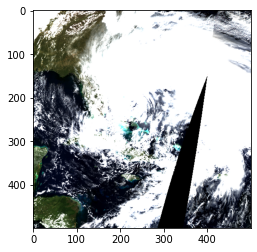

In [49]:
plt.imshow(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


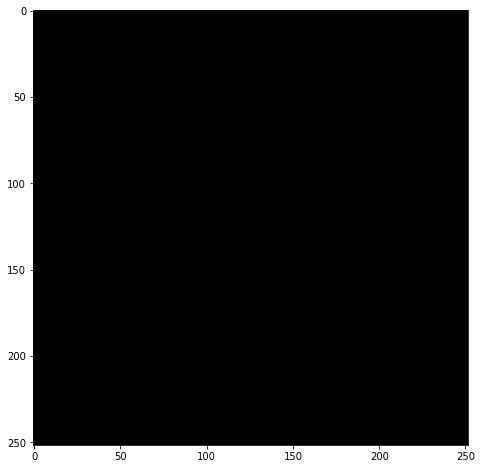

In [50]:
R_true = R_HL * 0.002
G_true = G_HL * 0.002
B_true = B_HL * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


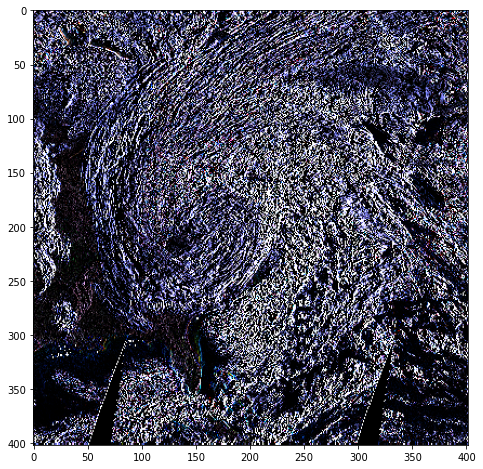

In [75]:

R_true = R_HL * 0.002
G_true = G_HL * 0.002
B_true = B_HL * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


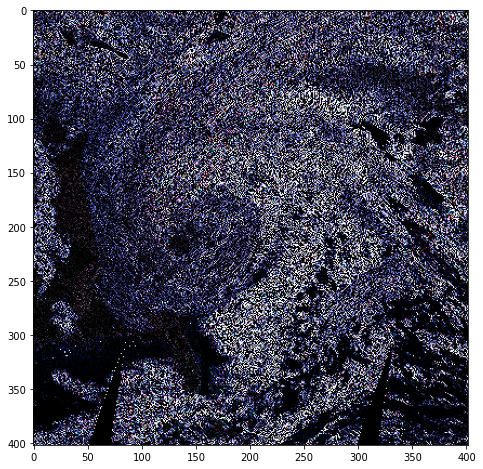

In [74]:

R_true = R_HH * 0.002
G_true = G_HH * 0.002
B_true = B_HH * 0.004

rgb = np.dstack([R_true, G_true, B_true])

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.show()

In [114]:
name = '/home/fun/data/AL012012/modis_satellite_20120519.npy'
file = np.load(name)
time = name[-12:-4]
time

'20120519'